In [38]:
# import libraries
import vtrigU as vtrig
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from math import ceil, log
from matplotlib.animation import FuncAnimation
from scipy import constants
from vtrigU_helper_functions import *
from IPython.display import display, clear_output

# define some constants
c = constants.c
antsLocations = ants_locations()

In [39]:
# Compute necessary values
Rmax = 15
BW = c*75/Rmax
print(62.0*1000+BW)


1499024290.0


In [40]:
# initialize the device
vtrig.Init()

# set setting structure
vtrigSettings = vtrig.RecordingSettings(
        vtrig.FrequencyRange(62.0*1000, # Start Frequency (in MHz)
                             66.5*1000, # Stop  Frequency (in MHz) (66.5 for 5m)
                             150),      # Number of Frequency Points (Maximum: 150)
        510.0,                           # RBW (in KHz)
        vtrig.VTRIG_U_TXMODE__LOW_RATE  # Tx Mode (LOW: 20 Tx, MED: 10 Tx, HIGH: 4 Tx)
        ) 

# validate settings
vtrig.ValidateSettings(vtrigSettings)

# apply settings
vtrig.ApplySettings(vtrigSettings)

# get antenna pairs and convert to numpy matrix
TxRxPairs = np.array(vtrig.GetAntennaPairs(vtrigSettings.mode))

# get used frequencies in Hz
freq = np.array(vtrig.GetFreqVector_MHz()) * 1e6

# define constants
N_txrx = TxRxPairs.shape[0]
N_freq = freq.shape[0]

Nfft = 2**(ceil(log(freq.shape[0],2))+1)
Ts = 1/Nfft/(freq[1]-freq[0]+1e-16) # Avoid nan checks
time_vec = np.linspace(0,Ts*(Nfft-1),num=Nfft)
dist_vec = time_vec*(c/2) # distance in meters

In [41]:
# For Testing Usage
vtrig.Record()
rec = vtrig.GetRecordingResult()
recArr = []
for key in rec.keys():
    recArr.append(rec[key])
recArr = np.array(recArr)

In [42]:
# xgrid = np.array([0,0]
xgrid = np.arange(-0.3, 0.3+0.03, 0.03)
ygrid = np.arange(-0.3, 0.3+0.03, 0.03)
zgrid = np.arange( 0.1, 1+0.02,   0.02)
[Xgrid,Ygrid,Zgrid] = np.meshgrid(xgrid,ygrid,zgrid)

src = np.stack((Xgrid, Ygrid, Zgrid),3).reshape((-1,3,1,1))
src2 = np.transpose(src,[2,1,3,0])
 
# Use Radar equation to find total loss
# Pe/Ps = (Gtx*Grx*RCS*lambda^2)/((4pi)^3*|Rtx|^2*|Rrx|^2)
Rvec = src2 - np.expand_dims(antsLocations,axis=[2,3])

Rmag = np.expand_dims(norm(Rvec,axis=1),axis=1)
Rtheta = np.expand_dims(np.arctan2(norm(Rvec[:,0:1,:,:],axis=1),Rvec[:,2,:,:]),axis=1)
Rphi = np.expand_dims(np.arctan2(Rvec[:,1,:,:],Rvec[:,0,:,:]),axis=1)
Sphase = 2*np.pi*Rmag*np.expand_dims(freq,axis=[0,2,3])/c #Electrical Length in Radians
curRCS = 1 #m^2
curLambda = c/freq 
csf = np.sqrt(curRCS)*curLambda/((4*np.pi)**(3/2)) 
Smag = 10**(5.8/20)*RadiationPattern(Rtheta,Rphi)/Rmag

H2 = np.zeros((len(TxRxPairs),len(freq),1,src2.shape[3]))
for i in range(len(TxRxPairs)):
    tx = TxRxPairs[i,0]-1
    rx = TxRxPairs[i,1]-1
    H2[i,:,:,:] = 1/(csf.reshape(1,-1,1,1)*Smag[tx,:,:,:]*Smag[rx,:,:,:]*np.exp(-1j*(Sphase[tx,:,:,:]+Sphase[rx,:,:,:])))

H2 = np.transpose(H2,[3,0,1,2]).reshape((src2.shape[3],-1))


c:\Users\SCKY\.conda\envs\vtrigU\lib\site-packages\ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


In [46]:
# Record the calibration frames
nrecs = 10
calFrame = []
for i in range(nrecs):
    vtrig.Record()
    rec = vtrig.GetRecordingResult()
    recArr = rec2arr(rec)
    calFrame.append(recArr)
calFrame = np.mean(calFrame,axis=0)

# Record frame and then process it to cartesian coordinates
nframes = 1
for i in range(nframes):
    vtrig.Record()
    rec = vtrig.GetRecordingResult()
    recArr = rec2arr(rec)
    print("record done!")
    X = recArr
    if i == 0:           
        # Identify resonant frequencies 
        thresh = 3
        lnconv = int(min(max(np.floor(N_freq/8)*2+1,np.floor(50/(freq[1]-freq[0]))*2+1),np.floor(3*N_freq/8)*2+1)); #conv length between 1/4 and 3/4 N_freq
        c2 = -np.ones(lnconv)/(lnconv-1)
        c2[(lnconv+1)//2] = 1
        padsig = 20*np.log10(norm(X,axis=0))
        padsig = np.concatenate([padsig[(lnconv-1)//2:0:-1],padsig,padsig[-1:len(padsig)-(lnconv-1)//2-1:-1]])
        padsig = np.convolve(padsig,c2,'valid')        
        f_res = padsig>thresh
    X = (X-calFrame) * (1-f_res)
    y_cart = (H2@X.reshape(-1,1)).reshape(Xgrid.shape)
   





record done!


In [47]:
np.save("X", X)
np.save("y_cart",y_cart)

In [83]:
print(Xgrid.shape)
print(y_cart.shape)
print((Xgrid*(abs(y_cart)>1500)).shape)

(21, 21, 46)
(21, 21, 46)
(21, 21, 46)


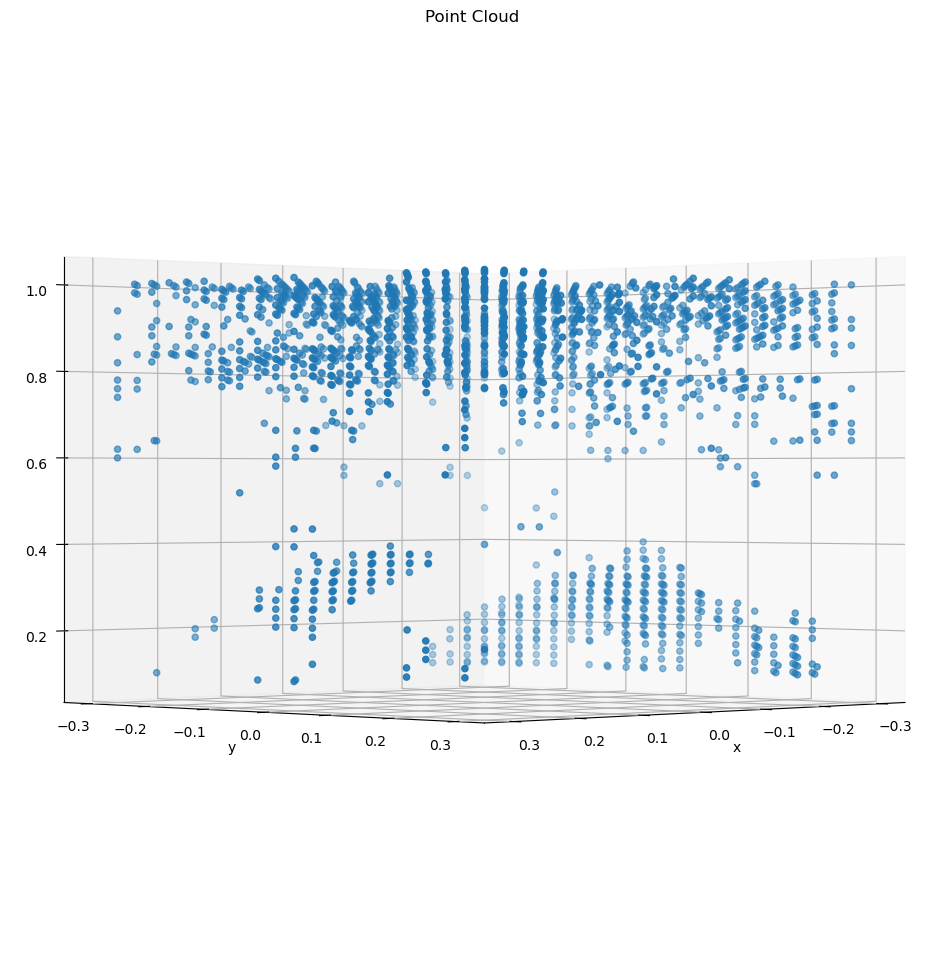

<Figure size 640x480 with 0 Axes>

In [105]:
# Plot the 3D point cloud
if min([len(xgrid),len(ygrid),len(zgrid)])>2:
        th = abs(y_cart)>1500
        plt.ion()
        fig = plt.figure(figsize=(12,12))
        ax = fig.add_subplot(projection='3d')   
        ax.scatter(Xgrid[th],Ygrid[th],Zgrid[th])
        # ax.scatter(Xgrid*th,Ygrid*th,Zgrid*th, c='blue')
        ax.view_init(0, 45)
        if i == 0:
            ax.set_title('Point Cloud')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_label('z')
            ax.set_aspect('auto')
            # ax.axis([xgrid[0],xgrid[-1],ygrid[1],ygrid[-1],zgrid[0],zgrid[-1],-20,20])
        plt.show()
        plt.close()
        plt.savefig('point_cloud',dpi=80)
        

In [ ]:
PDP = computePDP(X,Nfft)
plt.figure(figsize=(30,8))
plt.plot(dist_vec,convert2db(PDP))
plt.ylim((-50,50))
plt.show()
plt.close()